# Import des librairies de travail 

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.inspection import permutation_importance
from sklearn.utils import estimator_html_repr
from sklearn.base import clone
import seaborn as sns
#import statsmodels.api as sm

Importation du dataset (CSV)

In [2]:
df = pd.read_csv('/Users/gaillet/Desktop/LeWagon/projet/Extract_TimeFrame_60_clean.csv',delimiter=';')
df.head(3)

,time,open,high,low,close,Basis,Upper,Lower,Up Trend,Down Trend,KAMA,RSI,Bollinger Bands %b,Bollinger BandWidth,Highest Expansion,Lowest Contraction
0,11/01/2022 00:00,1801.23,1802.85,1800.03,1801.18,1796.565,1802.85,1790.28,1790.975815,NaN,1795.256156,65.669045,0.831694,0.803134,2.519134,0.332677
1,11/01/2022 01:00,1801.16,1804.61,1801.15,1802.70,1797.445,1804.61,1790.28,1792.424234,NaN,1795.536505,69.806836,0.888896,0.826182,2.519134,0.332677
2,11/01/2022 02:00,1802.68,1805.91,1802.00,1804.85,1798.095,1805.91,1790.28,1793.371810,NaN,1795.896520,74.665739,0.963492,0.876434,2.519134,0.332677


Copy du dataset pour travail : 

In [3]:
data = df.copy()
data.head(3)

,time,open,high,low,close,Basis,Upper,Lower,Up Trend,Down Trend,KAMA,RSI,Bollinger Bands %b,Bollinger BandWidth,Highest Expansion,Lowest Contraction
0,11/01/2022 00:00,1801.23,1802.85,1800.03,1801.18,1796.565,1802.85,1790.28,1790.975815,NaN,1795.256156,65.669045,0.831694,0.803134,2.519134,0.332677
1,11/01/2022 01:00,1801.16,1804.61,1801.15,1802.70,1797.445,1804.61,1790.28,1792.424234,NaN,1795.536505,69.806836,0.888896,0.826182,2.519134,0.332677
2,11/01/2022 02:00,1802.68,1805.91,1802.00,1804.85,1798.095,1805.91,1790.28,1793.371810,NaN,1795.896520,74.665739,0.963492,0.876434,2.519134,0.332677


Nettoyage du dataset :

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23112 entries, 0 to 23111
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 23112 non-null  object 
 1   open                 23112 non-null  float64
 2   high                 23112 non-null  float64
 3   low                  23112 non-null  float64
 4   close                23112 non-null  float64
 5   Basis                23112 non-null  float64
 6   Upper                23112 non-null  float64
 7   Lower                23112 non-null  float64
 8   Up Trend             12053 non-null  float64
 9   Down Trend           11059 non-null  float64
 10  KAMA                 23112 non-null  float64
 11  RSI                  23112 non-null  float64
 12  Bollinger Bands %b   23112 non-null  float64
 13  Bollinger BandWidth  23112 non-null  float64
 14  Highest Expansion    23112 non-null  float64
 15  Lowest Contraction   23112 non-null 

In [5]:
data['time'] = pd.to_datetime(data['time'], format='%d/%m/%Y %H:%M', utc=True)
print(data['time'].head(3))
data['time'].info()

0   2022-01-11 00:00:00+00:00
1   2022-01-11 01:00:00+00:00
2   2022-01-11 02:00:00+00:00
Name: time, dtype: datetime64[ns, UTC]
<class 'pandas.core.series.Series'>
RangeIndex: 23112 entries, 0 to 23111
Series name: time
Non-Null Count  Dtype              
--------------  -----              
23112 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 180.7 KB


In [16]:
data['Trend'] = np.where(data['Up Trend'].isna(), 0, 1)
data['Trend_value'] = data[['Up Trend','Down Trend']].sum(axis=1, skipna=True)
data.drop(columns='Up Trend',inplace=True)
data.drop(columns='Down Trend',inplace=True)
print(data['Trend'].head(3))
print(data['Trend_value'].head(3))

0    1
1    1
2    1
Name: Trend, dtype: int64
0    1790.975815
1    1792.424234
2    1793.371810
Name: Trend_value, dtype: float64


In [17]:
data.head(3)

,time,open,high,low,close,Basis,Upper,Lower,KAMA,RSI,Bollinger Bands %b,Bollinger BandWidth,Highest Expansion,Lowest Contraction,Trend,Trend_value
0,2022-01-11 00:00:00+00:00,1801.23,1802.85,1800.03,1801.18,1796.565,1802.85,1790.28,1795.256156,65.669045,0.831694,0.803134,2.519134,0.332677,1,1790.975815
1,2022-01-11 01:00:00+00:00,1801.16,1804.61,1801.15,1802.70,1797.445,1804.61,1790.28,1795.536505,69.806836,0.888896,0.826182,2.519134,0.332677,1,1792.424234
2,2022-01-11 02:00:00+00:00,1802.68,1805.91,1802.00,1804.85,1798.095,1805.91,1790.28,1795.896520,74.665739,0.963492,0.876434,2.519134,0.332677,1,1793.371810


In [18]:
data.isnull().sum() / len(data)

time                   0.0
open                   0.0
high                   0.0
low                    0.0
close                  0.0
Basis                  0.0
Upper                  0.0
Lower                  0.0
KAMA                   0.0
RSI                    0.0
Bollinger Bands %b     0.0
Bollinger BandWidth    0.0
Highest Expansion      0.0
Lowest Contraction     0.0
Trend                  0.0
Trend_value            0.0
dtype: float64

<Axes: xlabel='close', ylabel='Count'>

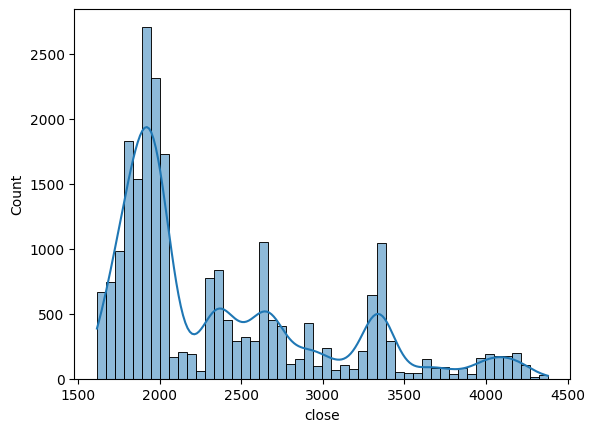

In [23]:
sns.histplot(data['close'], kde=True)

<Axes: xlabel='close', ylabel='Count'>

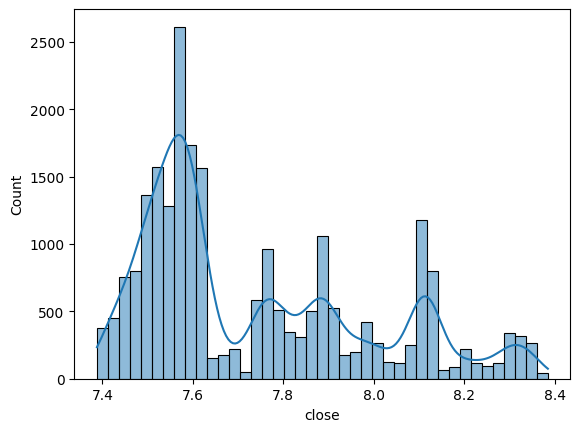

In [24]:
sns.histplot(np.log(data['close']), kde=True)

## Définition de la fonction pipeline

#### Création de la fonction pipeline comprenant la fonction de preprocessing et le model que l'on souhaite utilisé pour la baseline

In [ ]:
hourly_cols = ['dxy_ret', 'us10y_delta', 'vix_delta']     # example hourly features
monthly_cols = ['inflation_rate', 'breakeven_10y']

all_features = hourly_cols + monthly_cols

# target =

In [ ]:
class MonthlyToHourlyImputer(BaseEstimator, TransformerMixin):
   """
   Time-aware imputer for monthly features on an hourly DataFrame.
   - Repeats each monthly value across all hours in that calendar month.
   - Optionally lag releases to avoid leakage.
   - Works with a DataFrame (preserves column names).
   """
   def __init__(self, monthly_cols, anchor='start', lag_months=0, fill_method='ffill'):
       """
       monthly_cols: list of column names to treat as monthly series
       anchor: 'start' or 'end' (timestamp anchoring for monthly aggregation)
       lag_months: int, number of months to shift the monthly value forward (to avoid leakage)
       fill_method: 'ffill' or 'bfill' used after aligning
       """
       self.monthly_cols = monthly_cols
       self.anchor = anchor
       self.lag_months = lag_months
       self.fill_method = fill_method
   def fit(self, X, y=None):
       # Nothing to learn
       return self
   def transform(self, X):
       if not isinstance(X, pd.DataFrame):
           raise TypeError("MonthlyToHourlyImputer expects a pandas DataFrame.")
       if not isinstance(X.index, pd.DatetimeIndex):
           raise TypeError("DataFrame index must be a DatetimeIndex.")
       X = X.copy().sort_index()
       # Build monthly values for each column
       # Take the first non-null per calendar month (you can change to last())
       monthly = (
           X[self.monthly_cols]
           .groupby(X.index.to_period('M')).first()
           .to_timestamp(how=self.anchor)
       )
       # Apply lag in monthly calendar space to prevent look-ahead
       if self.lag_months != 0:
           monthly.index = monthly.index + pd.offsets.MonthBegin(self.lag_months)
       # Create a monthly-start index covering the range
       month_start_idx = pd.date_range(
           start=X.index.min().normalize().replace(day=1),
           end=X.index.max().normalize().replace(day=1),
           freq='MS'
       )
       monthly = monthly.reindex(month_start_idx)
       # Expand to hourly with ffill/bfill
       expanded = monthly.resample('H').ffill()
       if self.fill_method == 'bfill':
           expanded = monthly.resample('H').bfill()
       # Align back to X's hourly index
       aligned = expanded.reindex(X.index)
       # Use forward/backward fill for any leading NaNs (e.g., missing earliest month)
       aligned = aligned.ffill().bfill()
       # Replace columns in X
       for c in self.monthly_cols:
           X[c] = aligned[c]
       return

In [ ]:
X = df[all_features]
y = df[target]

split_idx = int(np.floor(len(X) * 0.7))
X_train = X.iloc[:split_idx].copy()
X_val  = X.iloc[split_idx:].copy()
y_train = y.iloc[:split_idx].copy()
y_val  = y.iloc[split_idx:].copy()

In [ ]:
# Preprocess step to make monthly features time-aware
time_imputer = MonthlyToHourlyImputer(monthly_cols=monthly_cols, anchor='start', lag_months=1)

X_train_imp = time_imputer.transform(X_train)
X_val_imp  = time_imputer.transform(X_val)

preprocess = ColumnTransformer(
   transformers=[
       ('scale_hourly', StandardScaler(with_mean=True), hourly_cols),
       ('scale_monthly', StandardScaler(with_mean=True), monthly_cols)
   ],
   remainder='drop'
)

pipe = Pipeline(steps=[
   ('monthly_imputer', time_imputer),# << time-aware step
   ('preprocess', preprocess),
   ('model', model)
])

### Cross validate le pipeline baseline

In [ ]:
# Cross-validate Pipeline
cv_score = cross_validate(pipe, X, y, cv=5, scoring='recall').mean()
cv_score